In [2]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
#import swifter
from scipy import stats

%matplotlib inline

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '________',
    'user': 'student',
    'database': 'simulator_20220920'
}

In [4]:
q = """
SELECT uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-09-21' and toDate(time) <= '2022-09-27' 
"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,68057


In [5]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-08-27' and '2022-09-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

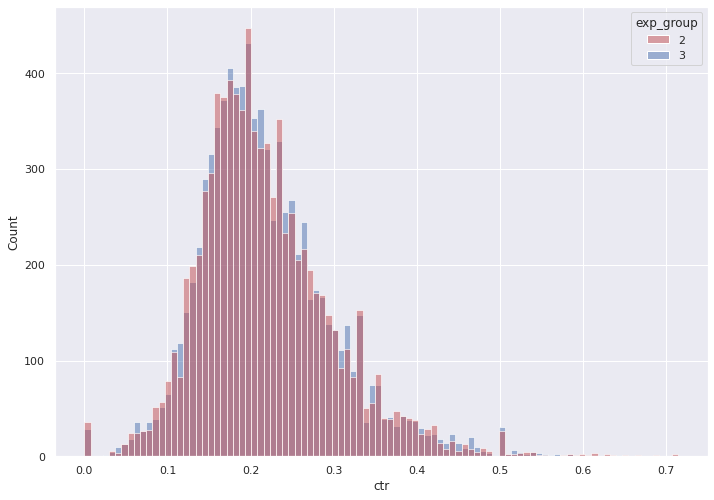

In [6]:
# Проверяем общие данные
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [7]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [8]:
df.groupby('exp_group', as_index = False) \
    .agg(['mean', 'std', 'count', 'sem']).transpose() \
    .round(5)

exp_group                2            3
user_id mean   69282.76698  69522.30552
        std    53428.42110  53281.22962
        count   8480.00000   8569.00000
        sem      580.19558    575.58460
likes   mean      15.53420     15.61279
        std       10.81464     10.66322
        count   8480.00000   8569.00000
        sem        0.11744      0.11519
views   mean      73.49387     74.09768
        std       48.33207     49.08130
        count   8480.00000   8569.00000
        sem        0.52485      0.53021
ctr     mean       0.21825      0.21916
        std        0.08064      0.08093
        count   8480.00000   8569.00000
        sem        0.00088      0.00087

Метрики в группах 1 и 2 очень схожи. Наши выборки статистически эквивалентны (на первый взгляд). Смотрим дальше

In [9]:
df_1 = df.query('exp_group == 2')

In [10]:
df_1.head()

,exp_group,user_id,likes,views,ctr
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
5,2,24239,53,119,0.445378
7,2,14680,8,70,0.114286


In [11]:
df_2 = df.query('exp_group == 3')

In [12]:
df_1.sample(n=500, replace=False)['ctr']

16664    0.125000
6118     0.178218
1087     0.196429
2373     0.215859
16787    0.219512
           ...   
11097    0.200000
16431    0.133333
2337     0.163934
1804     0.176471
6383     0.213483
Name: ctr, Length: 500, dtype: float64

In [13]:
# генерим выборки по 500 единиц из каждой группы и кидаем их в цикл с целью достать pvalue из t-теста
i = 0
p_values = []

for i in range(10000):
    r = stats.ttest_ind(df_1.sample(n=500, replace=False)['ctr'],
                        df_2.sample(n=500, replace=False)['ctr'],
                        equal_var=False)
    i += 1

    p_values.append(round(r[1], 3))

<AxesSubplot:ylabel='Count'>

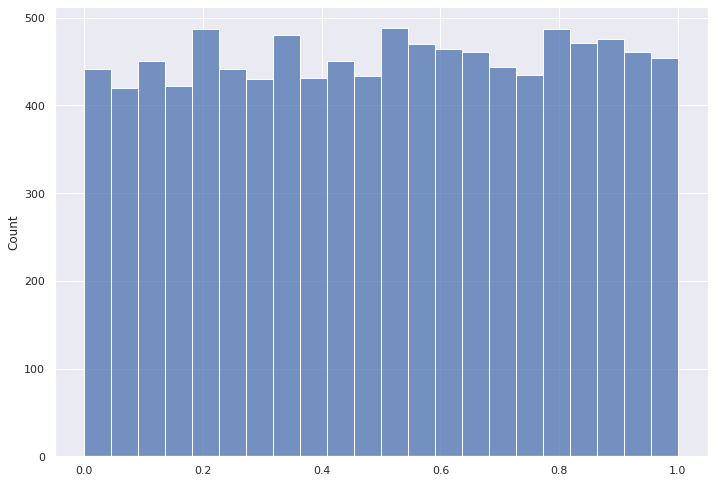

In [14]:
# Строим гистограмму распределения получившихся 10000 p-values.

sns.histplot(p_values)

In [16]:
#2. Cчитаем какой процент p values оказался меньше либо равен 0.05

p_values_check = 0.05
count = 0
for p_value in p_values:
    if p_value <= p_values_check: 
        count += 1
        
print(count/10000*100, '% значений p values оказались меньше или равны 0.05')

4.9 % значений p values оказались меньше или равны 0.05


# Вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

Исходя из данных наша система сплитования работает корректно. В ходе АА теста пользователи были поделены на группы, размер в них ~одинаков, показатели не отличаются. Ложных срабатываний меньше 5%, отличие не прокрасилось